In [411]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import re
import json

import gpxpy
import geopandas 

from IPython.core.display import HTML
pd.options.display.max_columns = 100
import datetime

from IPython.core.display import HTML
from ua_parser import user_agent_parser
import seaborn as sb
sb.set_style("whitegrid")
sb.set_style("white")

import ipywidgets as widgets

import pprint
pp = pprint.PrettyPrinter(indent=4)

HTML("<style>.container { width:100% !important; }</style>")

In [412]:
import spacy

nlp = spacy.load("nl_core_news_sm")
from wordcloud import WordCloud


In [413]:
data_raw = pd.read_csv('raw_data/2021-08-04_FINAL_LABELING_PEILING_VOORUIT.csv')
data_raw = data_raw.set_index('ID')
data_raw['Opleiding'] = data_raw['Opleiding'] = data_raw['Opleiding'].replace({
    'geef liever geen antwoord':'0_geef liever geen antwoord',
    'lagere school of geen diploma': '1_lagere school of geen diploma',
    'lager algemeen secundair onderwijs (1ste 3 jaar)' : '2_lager algemeen secundair onderwijs (1ste 3 jaar)',
    'lager TSO, BSO of artistiek (1ste 3 jaar)': '2_lager TSO, BSO of artistiek (1ste 3 jaar)',
    'hoger secundair beroepsonderwijs (BSO)': '3_hoger secundair beroepsonderwijs (BSO)',
    'hoger secundair technisch of artistiek onderwijs': '3_hoger secundair technisch of artistiek onderwijs',
    'hoger algemeen secundair onderwijs': '3_hoger algemeen secundair onderwijs',
    'kandidaat, bachelor, graduaat': '4_kandidaat, bachelor, graduaat',
    'licentiaat, master, postgraduaat': '5_licentiaat, master, postgraduaat',
    'licentiaat met aanvullend diploma, MaNaMa': '5_licentiaat met aanvullend diploma, MaNaMa',
    'doctoraat met thesis': '6_doctoraat met thesis',
})
data_raw.sample(10)

,Gender,Leeftijd,Provincie,Habitat,Opleiding,Beroep,Pot Groen,Pot CD&V,Pot N-VA,Pot Vooruit,Pot VB,Pot VLD,Pot PVDA,Voorkeur,Aversie,Stem 2019,Waarom sp.a in 2019 maar nu niet Vooruit?,Waarom niet sp.a in 2019 maar nu wel?,Vertrouwen BEL regering,Vertrouwen De Croo,Vertrouwen VLA regering,Vertrouwen Jambon,Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?,Conner Rousseau: Kent u ... ?,Meryame Kitir: Kent u ... ?,Frank Vandenbroucke: Kent u ... ?,Vincent Van Quickenborne: Kent u ... ?,Alexander De Croo: Kent u ... ?,Bart Somers: Kent u ... ?,Egbert Lachaert: Kent u ... ?,Hilde Crevits: Kent u ... ?,Joachim Coens: Kent u ... ?,Wouter Beke: Kent u ... ?,Annelies Verlinden: Kent u ... ?,Meyrem Almaci: Kent u ... ?,Petra De Sutter: Kent u ... ?,Tom Van Grieken: Kent u ... ?,Dries Van Langenhove: Kent u ... ?,Peter Mertens: Kent u ... ?,Bart De Wever: Kent u ... ?,Jan Jambon: Kent u ... ?,Theo Francken: Kent u ... ?,Ben Weyts: Kent u ... ?,Zuhal Demir: Kent u ... ?,Conner Rousseau: Potentieel,Meryame Kitir: Potentieel,Frank Vandenbroucke: Potentieel,Vincent Van Quickenborne: Potentieel,Alexander De Croo: Potentieel,Bart Somers: Potentieel,Egbert Lachaert: Potentieel,Hilde Crevits: Potentieel,Joachim Coens: Potentieel,Wouter Beke: Potentieel,Annelies Verlinden: Potentieel,Meyrem Almaci: Potentieel,Petra De Sutter: Potentieel,Tom Van Grieken: Potentieel,Dries Van Langenhove: Potentieel,Peter Mertens: Potentieel,Bart De Wever: Potentieel,Jan Jambon: Potentieel,Theo Francken: Potentieel,Ben Weyts: Potentieel,Zuhal Demir: Potentieel,Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?,Label positieve woorden Vooruit,Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?,Kolom,Label negatieve woorden Vooruit,Overall sentiment,Waarin verschilt Vooruit volgens u van sp.a?,Label verschil
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1114,Man,48,Antwerpen,Stedelijke gemeenten,"4_kandidaat, bachelor, graduaat",Huisman of huisvrouw,Nee,Nee,Nee,Nee,Ja,Nee,Nee,VB,"{Groen,CD&V,Vooruit,VLD}",VB,NaN,NaN,Helemaal geen vertrouwen,Helemaal geen vertrouwen,Helemaal geen vertrouwen,Helemaal geen vertrouwen,corruptie door politici,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,geen,Geen,oude wijn in nieuwe zakken,NaN,Marketingstunt,Negatief,in niets,Geen
566,Man,54,Antwerpen,Andere gemeenten,"4_kandidaat, bachelor, graduaat",Andere bediende die hoofdzakelijk kantoorwerk ...,Nee,Nee,Nee,Ja,Nee,Nee,Nee,Vooruit,"{Groen,CD&V,N-VA,VB,VLD}",sp.a,NaN,NaN,Redelijk vertrouwen,Veel vertrouwen,Redelijk vertrouwen,Weinig vertrouwen,Corona,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Nee,Ja,Ja,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Ja,Nee,Nee,Nee,Nee,Nee,X,Ongeldig,X,NaN,Ongeldig,Ongeldig,"Niets, enkel de naam is veranderd.",Naam
1151,Man,25,Oost-Vlaanderen,GROTE agglomeraties,"5_licentiaat met aanvullend diploma, MaNaMa",Vrij beroep,Nee,Nee,Nee,Ja,Ja,Ja,Nee,Vooruit,{Groen},sp.a,NaN,NaN,Weinig vertrouwen,Weinig vertrouwen,Weinig vertrouwen,Weinig vertrouwen,De jongeren in Brussel,Ja,Nee,Ja,Ja,Ja,Nee,Ja,Ja,Ja,Nee,Nee,Nee,Ja,Ja,Ja,Nee,Ja,Ja,Nee,Ja,Nee,Ja,NaN,Nee,Nee,Nee,NaN,Nee,Nee,Nee,NaN,NaN,NaN,Ja,Ja,Ja,NaN,Nee,Nee,NaN,Nee,NaN,"Het komt overeen met hun verleden, namelijk de...",Brand identity: naam,Ze stelen de naam,NaN,Gestolen naam,Evenwichtig,Er wordt meer nadruk gelegd op de toekomst,Beleid: toekomstgericht
898,Vrouw,68,Limburg,Sekundaire gemeenten,"4_kandidaat, bachelor, graduaat",Gepensioneerde,Ja,Nee,Nee,Nee,Nee,Ja,Nee,VLD,{VB},N-VA,NaN,NaN,Weinig vertrouwen,Redelijk vertrouwen,Weinig vertrouwen,Weinig vertrouwen,coronacrisis,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Ja,Nee,Nee,Nee,Nee,Ja,Nee,Nee,Ja,Nee,Nee,Ja,Nee,Nee,Nee,Nee,Ja,Ja,Nee,Nee,Nee,Nee,niet achteruit maar vooruit gaan,Innovatie - Vernieuwing,niet echt betrouwbaar,NaN,Onbetrouwbaar,Evenwichtig,jonger.,

## Beschrijvende statistieken

,Leeftijd_cat,Mannen,Vrouwen,Leeftijd
0,100 jaar en meer,0.004999,0.024756,102.5
1,95-99 jaar,0.098765,0.300719,97.5
2,90-94 jaar,0.535620,1.169369,92.5
3,85-89 jaar,1.579211,2.573310,87.5
4,80-84 jaar,2.670082,3.539043,82.5


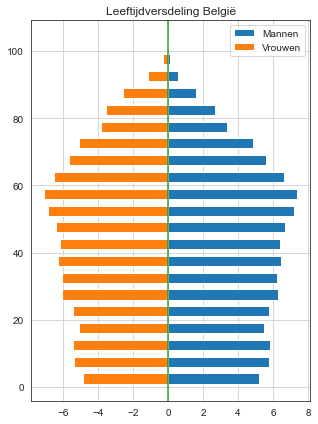

In [414]:
# Leeftijdsverdeling Belgische bevolking
leeftijdsverdeling = pd.read_csv('raw_data/2021-01-16 Leeftijdsverdeling België.csv')

leeftijdsverdeling = leeftijdsverdeling.rename(columns={'Leeftijd': 'Leeftijd_cat'})
leeftijdsverdeling['Leeftijd'] = leeftijdsverdeling['Leeftijd_cat'].str.extract(r'(?P<Leeftijd>[0-9]*)[- ]')
leeftijdsverdeling.loc[leeftijdsverdeling['Leeftijd_cat']=='Minder dan 5 jaar', 'Leeftijd'] = 0
leeftijdsverdeling['Leeftijd'] = leeftijdsverdeling['Leeftijd'].astype(float) + 2.5

leeftijdsverdeling['Mannen'] = leeftijdsverdeling['Mannen']*100/leeftijdsverdeling['Mannen'].sum()
leeftijdsverdeling['Vrouwen'] = leeftijdsverdeling['Vrouwen']*100/leeftijdsverdeling['Vrouwen'].sum()

fig, ax = plt.subplots(1,1, figsize=(5,7))

ax.barh(y=leeftijdsverdeling['Leeftijd'], width=leeftijdsverdeling['Mannen'], height=3, label='Mannen')
ax.barh(y=leeftijdsverdeling['Leeftijd'], width=-leeftijdsverdeling['Vrouwen'], height=3, label='Vrouwen')
ax.axvline(0, c='C2')

ax.set_title('Leeftijdversdeling België')
ax.legend()
ax.grid()

leeftijdsverdeling.head(5)

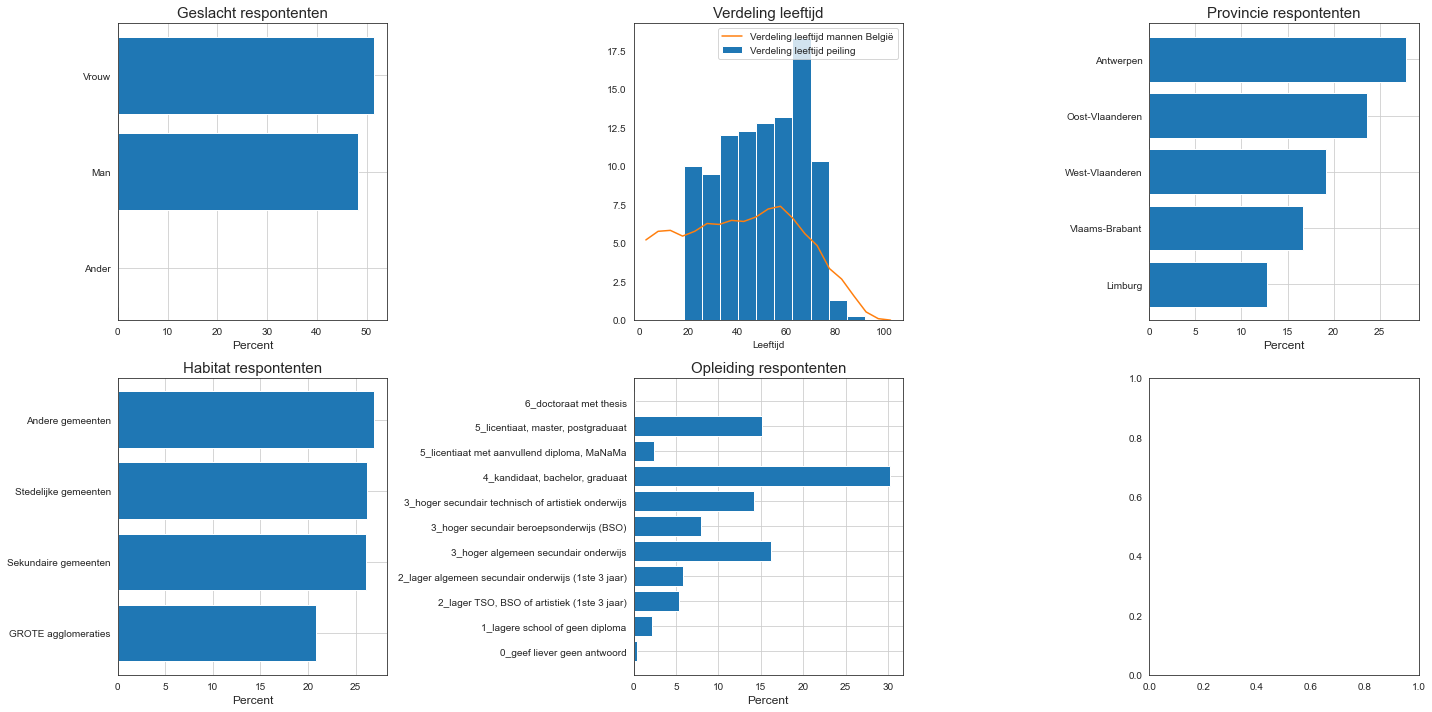

In [415]:
fig, axes = plt.subplots(2,3,figsize=(20,10))

# Value counts sex
geslacht_value_counts = data_raw['Gender'].value_counts(normalize=True).sort_values()*100
axes[0][0].barh(width=geslacht_value_counts.values, y=np.arange(len(geslacht_value_counts)), tick_label=geslacht_value_counts.index.values)
axes[0][0].set_title('Geslacht respontenten', size=15)
axes[0][0].grid()
axes[0][0].set_xlabel('Percent', size=12)

# Histogram age
axes[0][1].hist(x=data_raw['Leeftijd'], weights=(np.zeros_like(data_raw['Leeftijd']) + 1. / data_raw['Leeftijd'].size)*100, label='Verdeling leeftijd peiling')
axes[0][1].set_title('Verdeling leeftijd', size=15)
axes[0][1].plot(leeftijdsverdeling['Leeftijd'], leeftijdsverdeling['Mannen'], label='Verdeling leeftijd mannen België')
axes[0][1].set_xlabel('Leeftijd')
axes[0][1].legend()

# Provincie
provincie_value_counts = data_raw['Provincie'].value_counts(normalize=True).sort_values()*100
axes[0][2].barh(width=provincie_value_counts.values, y=np.arange(len(provincie_value_counts)), tick_label=provincie_value_counts.index.values)
axes[0][2].set_title('Provincie respontenten', size=15)
axes[0][2].grid()
axes[0][2].set_xlabel('Percent', size=12)

# Habitat
habitat_value_counts = data_raw['Habitat'].value_counts(normalize=True).sort_values()*100
axes[1][0].barh(width=habitat_value_counts.values, y=np.arange(len(habitat_value_counts)), tick_label=habitat_value_counts.index.values)
axes[1][0].set_title('Habitat respontenten', size=15)
axes[1][0].grid()
axes[1][0].set_xlabel('Percent', size=12)

# Opleiding
opleiding_value_counts = data_raw['Opleiding'].value_counts(normalize=True).sort_index()*100
axes[1][1].barh(width=opleiding_value_counts.values, y=np.arange(len(opleiding_value_counts)), tick_label=opleiding_value_counts.index.values)
axes[1][1].set_title('Opleiding respontenten', size=15)
axes[1][1].grid()
axes[1][1].set_xlabel('Percent', size=12)



fig.tight_layout()

Text(0.5, 0, 'Percent')

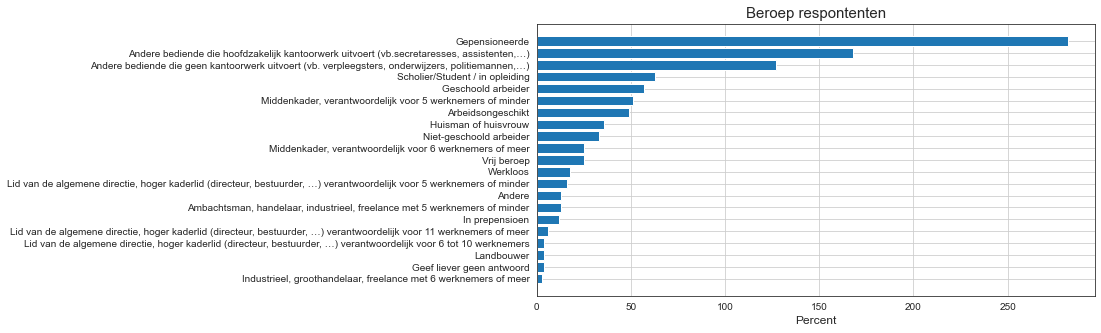

In [416]:
# Beroep
fig, ax = plt.subplots(1,1,figsize=(10,5))

beroep_value_counts = data_raw['Beroep'].value_counts().sort_values()
ax.barh(width=beroep_value_counts.values, y=np.arange(len(beroep_value_counts)), tick_label=beroep_value_counts.index.values)
ax.set_title('Beroep respontenten', size=15)
ax.grid()
ax.set_xlabel('Percent', size=12)

## Politieke voorkeur

In [417]:
data_raw['Voorkeur'] = data_raw['Voorkeur'].replace({
    'PVDA': '1_PVDA',
    'Groen': '2_Groen',
    'Vooruit':'3_Vooruit',
    'CD&V': '4_CD&V',
    'VLD':'5_VLD',
    'N-VA':'6_N-VA',
    'VB': '7_VB',
})

In [418]:
# Filter function
def filter_function(radio_buttons):
    
    # New filtered df
    data_filtered = data_raw.copy()
    data_filtered = data_filtered.loc[~data_filtered['Voorkeur'].isin(['Ander','Weiger','Niet stemmen', 'Weet niet']),:]    
    output.clear_output(wait=True)
    fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # Filter geslacht
    if(geslacht_radio_buttons.value in ['Man', 'Vrouw']):
        data_filtered = data_filtered.loc[(data_filtered['Gender'] == geslacht_radio_buttons.value),:]
    
    # Filter provincie
    if(provincie_radio_buttons.value in ['Antwerpen', 'Oost-Vlaanderen', 'West-Vlaanderen', 'Vlaams-Brabant', 'Limburg']):
        data_filtered = data_filtered.loc[(data_filtered['Provincie'] == provincie_radio_buttons.value),:]
    
    # Filter leeftijd
    if(leeftijd_radio_buttons.value=='jonger dan 25'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd']<26,:]
    elif(leeftijd_radio_buttons.value=='26-35'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(25, 35),:]
    elif(leeftijd_radio_buttons.value=='36-45'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(36, 45),:]
    elif(leeftijd_radio_buttons.value=='46-55'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(46, 55),:]
    elif(leeftijd_radio_buttons.value=='56-65'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(56, 65),:]
    elif(leeftijd_radio_buttons.value=='ouder dan 66'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd']>65,:]        
        
    # Show output
    #with output:
    #    display(len(data_filtered))
        
    # Plot
    with output:
        voorkeur_value_counts = data_filtered['Voorkeur'].value_counts(normalize=True).sort_index()*100
        plt.bar(x=np.arange(len(voorkeur_value_counts)), height=voorkeur_value_counts.values, width=0.5, tick_label=voorkeur_value_counts.index)
        plt.grid()
        plt.xticks(rotation = 45)
        plt.title('Voorkeur partij van de responenten\nAantal responenten na filter: {}'.format(len(data_filtered)), size=15)
        plt.ylim(top=40)
        plt.show()
        

# Geslacht radio buttons
geslacht_radio_buttons = widgets.RadioButtons(
    options=['Man', 'Vrouw', 'Beiden'],
    description='Geslacht: ',
    disabled=False
)
geslacht_radio_buttons.observe(filter_function)

# Provincie radio buttons
provincie_radio_buttons = widgets.RadioButtons(
    options=['Antwerpen', 'Oost-Vlaanderen', 'West-Vlaanderen', 'Vlaams-Brabant', 'Limburg', 'Alle'],
    description='Provincie: ',
    disabled=False
)
provincie_radio_buttons.observe(filter_function)

# Leeftijd radiobuttons
leeftijd_radio_buttons = widgets.RadioButtons(
    options=['jonger dan 25', '26-35', '36-45', '46-55', '56-65', 'ouder dan 66', 'Alle'],
    description='Leeftijd: ',
    disabled=False
)
leeftijd_radio_buttons.observe(filter_function)

# HBox with all the filters
input_widgets = widgets.HBox([geslacht_radio_buttons, leeftijd_radio_buttons, provincie_radio_buttons])
display(input_widgets)

# Output
output = widgets.Output()
display(output)
    

Output()

### Clean omschrijvingen

In [419]:
replace_dict = {
    'geen idee':'-',
    '/':'-',
    'geen':'-',
    'weet niet':'-',
    '?':'-',
    'Geen': '-',
    'geen': '-',
    'geen idee': '-',
    '/':'-',
    'Geen idee': '-',
    '?':'-',
    'Weet niet': '-',
    'Niets': '-',
    'geen enkele': '-',
    'niks':'-',
    'geen enkel':'-',
    'weet niet':'-',
    'Niks':'-',
    'geen mening': '-',
    'nihil':'-',
    'GEEN IDEE':'-',
    'GEEN':'',
    'niets':'-',
    'nee':'-',
    'Ik Weet Het Niet':'-',
    'Geen.':'-',
    'Weet Ik Niet': '-',
    'Geen Mening': '-',
    '??':'-',
    '':'-',
    'Nvt':'-',
    'nvt':'-',
    '1':'-',
    'Ik Weet Niet': '-',
    'Ik Zou Het Niet Weten':'-',
    'Weet Niet':'-',
    '????':'-',
    'Zou Niet Weten':'-',
    '......':'-',
    'Heb Er Geen':'-',
    'Kzou Het Niet Weten':'-',
    'weet ik niet':'-',
    'geen.':'-'    
}

data_raw['Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?'] = data_raw['Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?'].str.lower()
data_raw['Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?'] = data_raw['Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?'].replace(replace_dict)
data_raw['Grootste probleem'] = data_raw['Grootste probleem is waarmee ons land momenteel wordt geconfronteerd?']

data_raw['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'] = data_raw['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'].str.lower()
data_raw['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'] = data_raw['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'].replace(replace_dict)

data_raw['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?'] = data_raw['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?'].str.lower()
data_raw['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?'] = data_raw['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?'].replace(replace_dict)

## Positieve woorden om Vooruit te omschrijven

In [420]:
naamwoorden_pos = []
adjectieven_pos = []
row_mask = ((data_raw['Overall sentiment']=='Positief') & (data_raw['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?']!='-'))
for i, beschrijving in enumerate(data_raw.loc[row_mask, 'Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?']):

    #if(i>100): break
    doc = nlp(beschrijving)
    for token in doc:
        if(token.text in ['naam', 'partij']):continue
        if((token.pos_)=='NOUN'): naamwoorden_pos.append(token.text)
        if((token.pos_)=='ADJ'): adjectieven_pos.append(token.text)


### Positieve naamwoorden

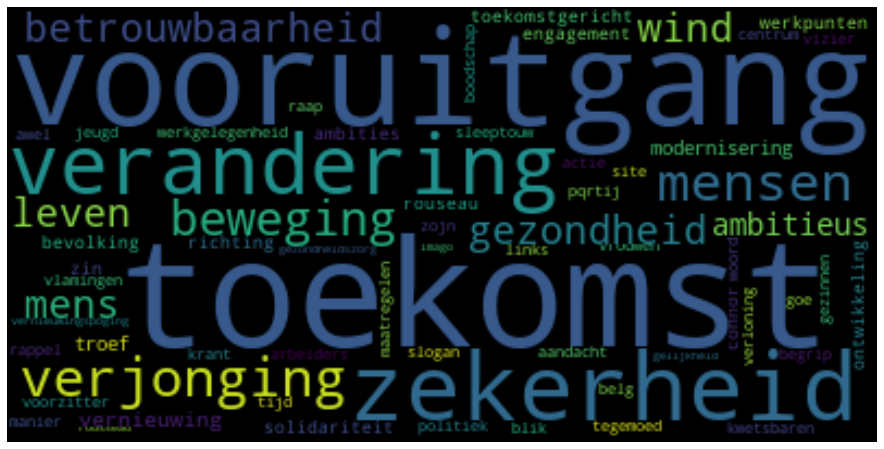

In [421]:
wordcloud = WordCloud().generate(' '.join(naamwoorden_pos))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Positieve adjectieven

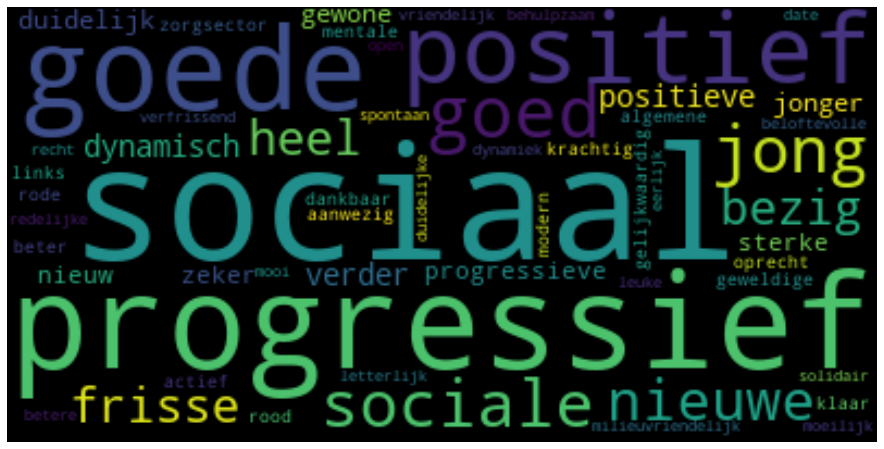

In [422]:
wordcloud = WordCloud().generate(' '.join(adjectieven_pos))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Negatieve woorden om Vooruit te beschrijven

In [425]:
naamwoorden_neg = []
adjectieven_neg = []
row_mask = ((data_raw['Overall sentiment']=='Negatief') & (data_raw['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?']!='-'))
for i, beschrijving in enumerate(data_raw.loc[row_mask, 'Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?']):

    #if(i>100): break
    doc = nlp(beschrijving)
    for token in doc:
        if(token.text in ['naam', 'partij']):continue
        
        if((token.pos_)=='NOUN'): naamwoorden_neg.append(token.text)
        if((token.pos_)=='ADJ'): adjectieven_neg.append(token.text)


### Negatieve naamwoorden

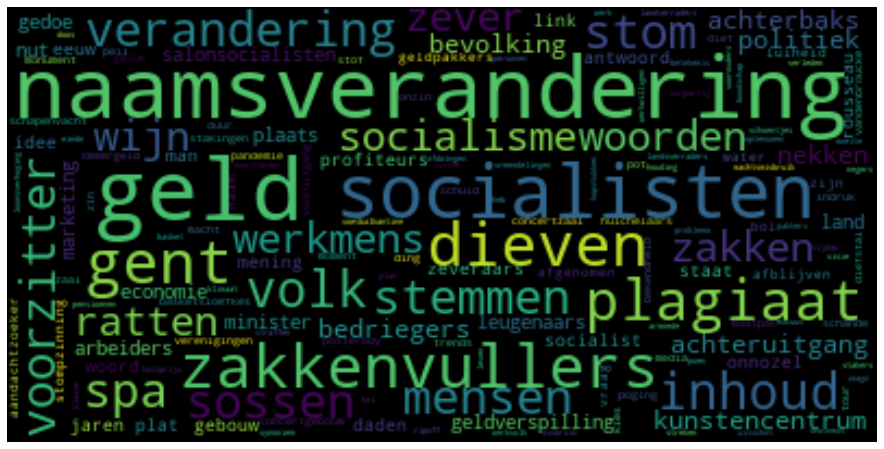

In [426]:
wordcloud = WordCloud().generate(' '.join(naamwoorden_neg))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Negatieve adjectieven

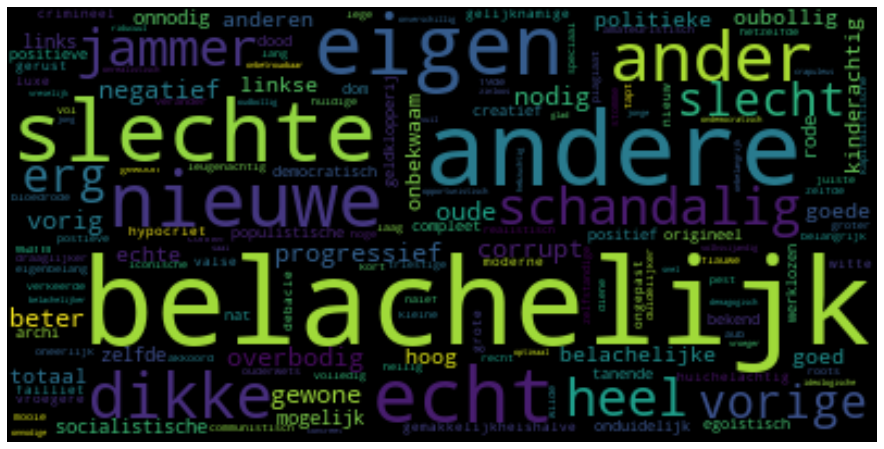

In [427]:
wordcloud = WordCloud().generate(' '.join(adjectieven_neg))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Grootste probleem dit land

In [428]:
replace_dict = {
    'covid':'corona',
    'covid 19':'corona',
    'covid19': 'corona',
    'pandemie':'corona',
    'covid-19':'corona',
    'coronavirus':'corona',
    'de pandemie':'corona',
    'de coronacrisis':'corona',
    'coronacrisis':'corona',
}
data_raw['Grootste probleem'] = data_raw['Grootste probleem'].replace(replace_dict)

In [429]:
row_mask = data_raw['Grootste probleem'].str.contains('corona') | data_raw['Grootste probleem'].str.contains('pandemie') | data_raw['Grootste probleem'].str.contains('covid')
data_raw.loc[row_mask, 'Grootste probleem'] = 'corona'

In [430]:
print('{:.1f}% van de respondenten vind corona het grootste probleem'.format(np.mean(data_raw['Grootste probleem']=='corona')*100))

31.9% van de respondenten vind corona het grootste probleem


In [431]:
row_mask = (data_raw['Grootste probleem'] != 'corona') & (data_raw['Grootste probleem'] != '-')
grootste_problemen = data_raw.loc[row_mask,'Grootste probleem']


In [432]:
naamwoorden_problemen = []
adjectieven_problemen = []
for i, probleem in enumerate(grootste_problemen):

    #if(i>100): break
    doc = nlp(probleem)
    for token in doc:
        if(token.text in ['naam', 'partij']):continue
        
        if((token.pos_)=='NOUN'): naamwoorden_problemen.append(token.text)
        if((token.pos_)=='ADJ'): adjectieven_problemen.append(token.text)


### Naamwoorden grootste problemen

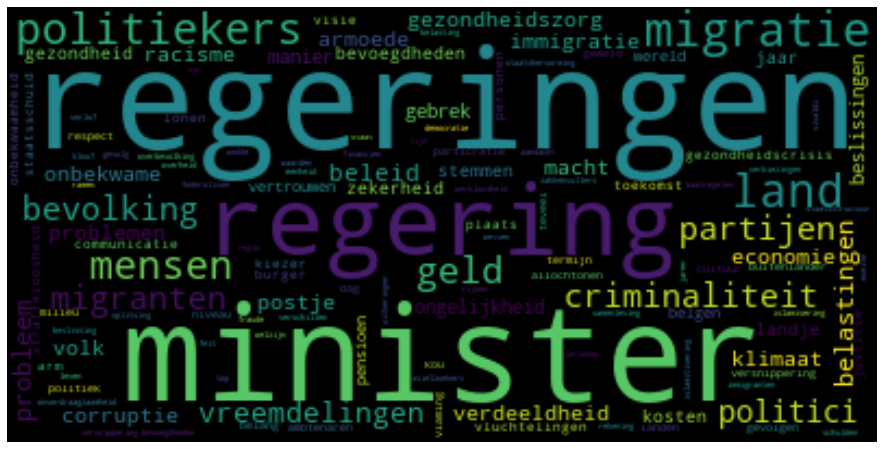

In [433]:
wordcloud = WordCloud().generate(' '.join(naamwoorden_problemen))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Adjectieven grootste problemen

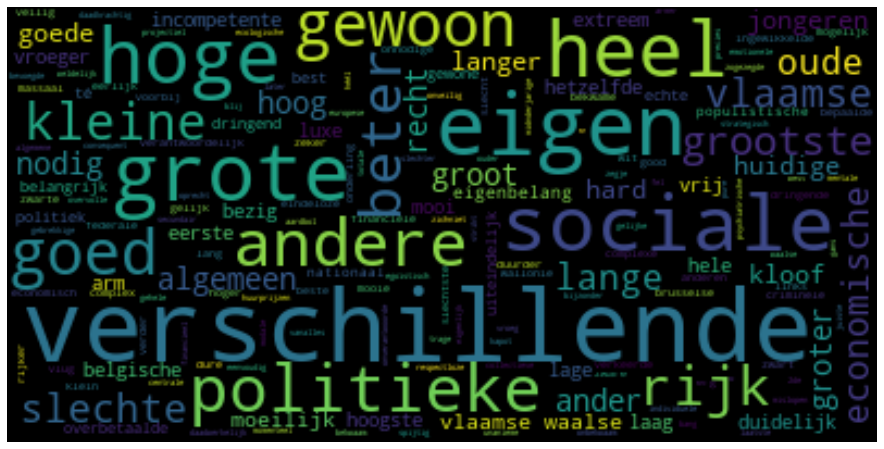

In [434]:
wordcloud = WordCloud().generate(' '.join(adjectieven_problemen))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Interactive grootste problemen

In [436]:
# Filter function
def filter_function(radio_buttons):
        
    # New filtered df
    row_mask = (data_raw['Grootste probleem'] != 'corona') & (data_raw['Grootste probleem'] != '-')
    data_filtered = data_raw.loc[row_mask,:].copy()
    
    #fig, ax = plt.subplots(1,1,figsize=(10,5))
    
    # Filter geslacht
    if(geslacht_radio_buttons.value in ['Man', 'Vrouw']):
        data_filtered = data_filtered.loc[(data_filtered['Gender'] == geslacht_radio_buttons.value),:]
    
    # Filter provincie
    if(provincie_radio_buttons.value in ['Antwerpen', 'Oost-Vlaanderen', 'West-Vlaanderen', 'Vlaams-Brabant', 'Limburg']):
        data_filtered = data_filtered.loc[(data_filtered['Provincie'] == provincie_radio_buttons.value),:]
    
    # Filter leeftijd
    if(leeftijd_radio_buttons.value=='jonger dan 25'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd']<26,:]
    elif(leeftijd_radio_buttons.value=='26-35'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(25, 35),:]
    elif(leeftijd_radio_buttons.value=='36-45'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(36, 45),:]
    elif(leeftijd_radio_buttons.value=='46-55'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(46, 55),:]
    elif(leeftijd_radio_buttons.value=='56-65'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd'].between(56, 65),:]
    elif(leeftijd_radio_buttons.value=='ouder dan 66'):
        data_filtered = data_filtered.loc[data_filtered['Leeftijd']>65,:]   
    
    # Filter politieke voorkeuren
    if(voorkeuren_radio_buttons.value != 'Alle'):
        data_filtered = data_filtered.loc[(data_filtered['Voorkeur'] == voorkeuren_radio_buttons.value),:]    
        
    # Calculate word cloud
    naamwoorden_problemen = []
    adjectieven_problemen = []
    for i, probleem in enumerate(data_filtered['Grootste probleem']):

        #if(i>100): break
        doc = nlp(probleem)
        for token in doc:
            if(token.text in ['naam', 'partij']):continue

            if((token.pos_)=='NOUN'): naamwoorden_problemen.append(token.text)
            if((token.pos_)=='ADJ'): adjectieven_problemen.append(token.text)    
        
    # Plot
    with output:
        output.clear_output(wait=True)
        print('Wordcloud gebaseerd op {} respondenten (enkel respondenten die iets anders dan Corona antwoordden!)'.format(len(data_filtered)))
        wordcloud = WordCloud().generate(' '.join(naamwoorden_problemen))

        plt.figure(figsize=(20,8))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        
        most_occuring = pd.Series(naamwoorden_problemen).value_counts().head(5).index
        
        row_mask = data_filtered['Grootste probleem'].str.contains('|'.join(most_occuring))
        examples = data_filtered.loc[row_mask, 'Grootste probleem'].sample(min(len(data_filtered.loc[row_mask,:]), 10)).values
        print('Voorbeelden')
        print('-----------')
        for example in examples:
            if(len(example)>50):continue
            print(example)
        
#        print(pd.Series(naamwoorden_problemen).value_counts().head(5))
        

# Geslacht radio buttons
geslacht_radio_buttons = widgets.RadioButtons(
    options=['Man', 'Vrouw', 'Beiden'],
    description='Geslacht: ',
    disabled=False,
    value='Beiden',
)
geslacht_radio_buttons.observe(filter_function, names=['value'])

# Provincie radio buttons
provincie_radio_buttons = widgets.RadioButtons(
    options=['Antwerpen', 'Oost-Vlaanderen', 'West-Vlaanderen', 'Vlaams-Brabant', 'Limburg', 'Alle'],
    description='Provincie: ',
    disabled=False,
    value='Alle'
)
provincie_radio_buttons.observe(filter_function, names=['value'])

# Leeftijd radiobuttons
leeftijd_radio_buttons = widgets.RadioButtons(
    options=['jonger dan 25', '26-35', '36-45', '46-55', '56-65', 'ouder dan 66', 'Alle'],
    description='Leeftijd: ',
    disabled=False,
    value='Alle',
)
leeftijd_radio_buttons.observe(filter_function, names=['value'])

# Radio buttons voorkeuren
voorkeuren_options = ['6_N-VA', '5_VLD', '7_VB', '2_Groen', 'Niet stemmen', 'Blanco',
                               '3_Vooruit', '1_PVDA', 'Weet niet', '4_CD&V', 'Weiger', 'Ander', 'Alle']
voorkeuren_options.sort()
voorkeuren_radio_buttons = widgets.RadioButtons(
    options=voorkeuren_options,
    description='Politieke voorkeur:',
    disabled=False,
    value='Alle')
voorkeuren_radio_buttons.observe(filter_function, names=['value'])

# HBox with all the filters
input_widgets = widgets.HBox([geslacht_radio_buttons, leeftijd_radio_buttons, provincie_radio_buttons, voorkeuren_radio_buttons])
display(input_widgets)

# Output
output = widgets.Output()
display(output)
    

Output()

## Potentieel andere partijen

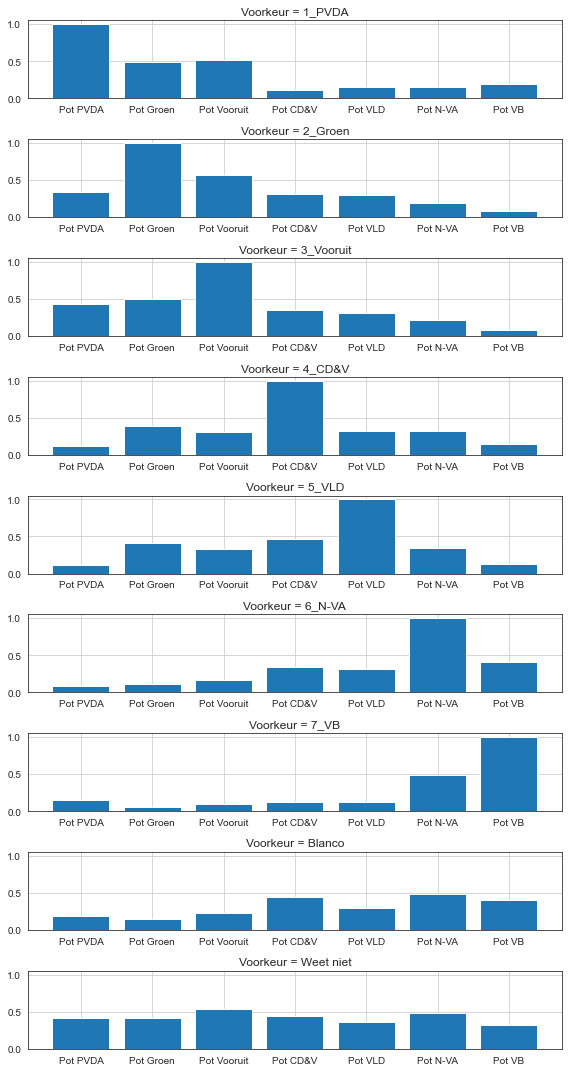

In [476]:
fig, axes = plt.subplots(9,1, figsize=(8,15), sharey=True)

j=0
for i, voorkeur in enumerate(np.unique(data_raw['Voorkeur'])):
    
    if(voorkeur in ['Ander', 'Niet stemmen', 'Weiger']):continue
    
    subset = data_raw.loc[(data_raw['Voorkeur']==voorkeur),:]

    potentieel_groen = np.mean(subset['Pot Groen']=='Ja')
    potentieel_CDV =  np.mean(subset['Pot CD&V']=='Ja')
    potentieel_NVA =  np.mean(subset['Pot N-VA']=='Ja')
    potentieel_Vooruit =  np.mean(subset['Pot Vooruit']=='Ja')
    potentieel_VLD =  np.mean(subset['Pot VLD']=='Ja')
    potentieel_VB =  np.mean(subset['Pot VB']=='Ja')
    potentieel_PVDA =  np.mean(subset['Pot PVDA']=='Ja')
    
    axes[j].bar(x=np.arange(7), height=[potentieel_PVDA, potentieel_groen, potentieel_Vooruit, potentieel_CDV, potentieel_VLD, potentieel_NVA, potentieel_VB], 
                tick_label=['Pot PVDA', 'Pot Groen', 'Pot Vooruit','Pot CD&V', 'Pot VLD','Pot N-VA', 'Pot VB'])
    axes[j].set_title('Voorkeur = '+ voorkeur)
    axes[j].grid()
    
    j+=1
    
fig.tight_layout()

Text(0, 0.5, 'Percentage')

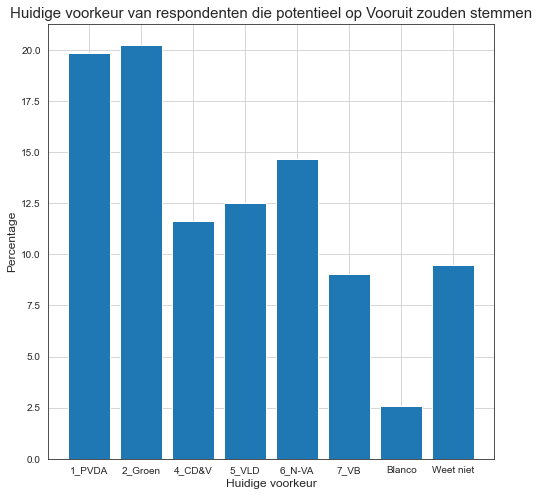

In [509]:
potentieel_vooruit = data_raw.loc[((data_raw['Pot Vooruit']=='Ja') & (~data_raw['Voorkeur'].isin(['3_Vooruit', 'Ander', 'Weiger', 'Niet stemmen']))),:]
potentieel_vooruit = potentieel_vooruit['Voorkeur'].value_counts(normalize=True).sort_index()*100

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.bar(tick_label=potentieel_vooruit.index, 
      x=np.arange(1,9), 
      height=potentieel_vooruit.values)

ax.grid()
ax.set_title('Huidige voorkeur van respondenten die potentieel op Vooruit zouden stemmen', size=15)
ax.set_xlabel('Huidige voorkeur', size=12)
ax.set_ylabel('Percentage', size=12)

## Overall sentiment

Text(0.5, 0, 'Huidige voorkeur')

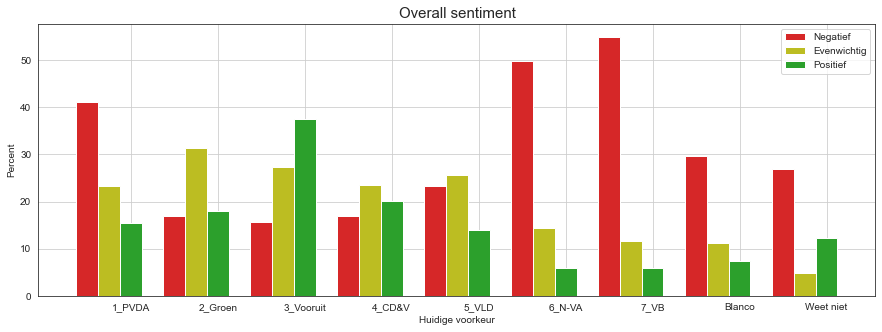

In [629]:
overall_sentiment = data_raw.groupby('Voorkeur')['Overall sentiment'].value_counts(normalize=True)
overall_sentiment = overall_sentiment.reset_index(level=0)
overall_sentiment.columns = ['Voorkeur', 'Percent']
overall_sentiment['Percent'] = overall_sentiment['Percent']*100
overall_sentiment = overall_sentiment.reset_index()

overall_sentiment = overall_sentiment.loc[~overall_sentiment['Voorkeur'].isin(['Weiger', 'Niet stemmen', 'Ander']),:]

fig, ax = plt.subplots(1,1, figsize=(15, 5))

row_mask = (overall_sentiment['Overall sentiment']=='Negatief')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))-0.25, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Negatief', color='C3', width=0.25)

row_mask = (overall_sentiment['Overall sentiment']=='Evenwichtig')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))+0, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Evenwichtig', color='C8', width=0.25)

row_mask = (overall_sentiment['Overall sentiment']=='Positief')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))+0.25, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Positief', color='C2', width=0.25)


ax.set_title('Overall sentiment', size=15)
ax.grid()
ax.legend()
ax.set_ylabel('Percent')
ax.set_xlabel('Huidige voorkeur')


## Positief label

In [554]:
data_copy = data_raw.copy()
data_copy = data_copy.loc[~data_copy['Voorkeur'].isin(['Niet stemmen', 'Weiger', 'Ander'])]
data_copy = data_copy.loc[data_copy['Gender']!='Ander',:]



Output()

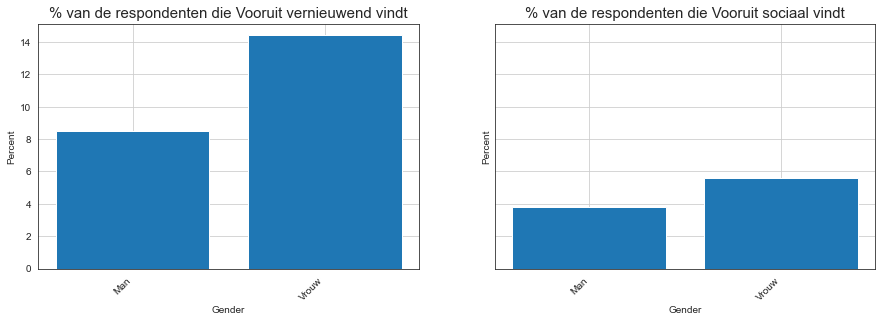

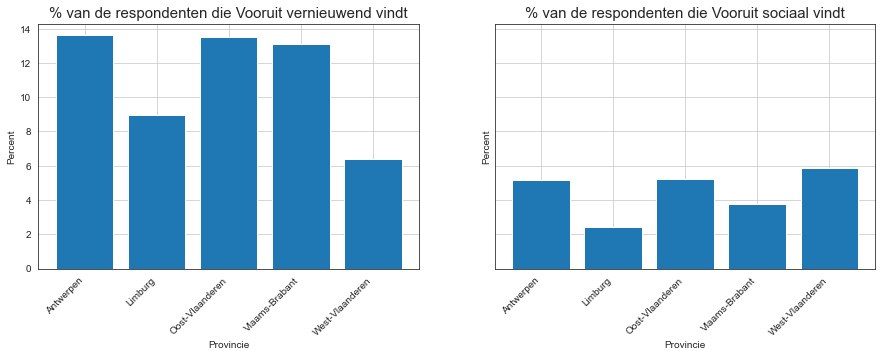

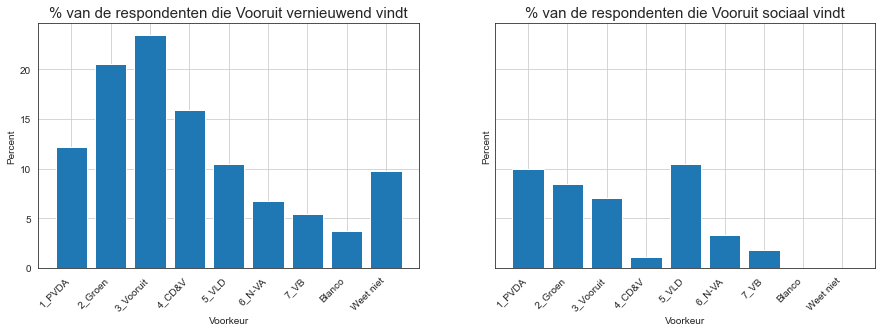

In [576]:
# Vernieuwend
data_copy['Vernieuwend'] = (data_copy['Label positieve woorden Vooruit'] == 'Innovatie - Vernieuwing')
mean_vernieuwend_per_partij = data_copy.groupby('Voorkeur')['Vernieuwend'].mean()*100

# Sociaal
data_copy['Sociaal'] = (data_copy['Label positieve woorden Vooruit'] == 'Sociaal')
mean_sociaal_per_partij = data_copy.groupby('Voorkeur')['Sociaal'].mean()*100


# Filter function
def filter_function(radio_buttons):
        
    grouped_data_vernieuwed = data_copy.groupby(categorie_radio_buttons.value)['Vernieuwend'].mean()*100
    grouped_data_sociaal = data_copy.groupby(categorie_radio_buttons.value)['Sociaal'].mean()*100
    
    # Plot
    with output:
        
        output.clear_output(wait=True)
        
        fig, axes = plt.subplots(1,2,figsize=(15,5), sharey=True)
        
        axes[0].bar(height=grouped_data_vernieuwed.values, tick_label=grouped_data_vernieuwed.index, x=np.arange(len(grouped_data_vernieuwed)))
        axes[0].grid()
        axes[0].set_title('% van de respondenten die Vooruit vernieuwend vindt', size=15)
        axes[0].set_ylabel('Percent')
        axes[0].set_xlabel(categorie_radio_buttons.value)

        axes[1].bar(height=grouped_data_sociaal.values, tick_label=grouped_data_sociaal.index, x=np.arange(len(grouped_data_sociaal)))
        axes[1].grid()
        axes[1].set_title('% van de respondenten die Vooruit sociaal vindt', size=15)
        axes[1].set_ylabel('Percent')
        axes[1].set_xlabel(categorie_radio_buttons.value)

        fig.autofmt_xdate(rotation=45 )        
        
# Categorie buttons
categorie_radio_buttons = widgets.RadioButtons(
    options=['Voorkeur', 'Gender', 'Provincie'],
    description='Categorie: ',
    disabled=False,
    value='Voorkeur',
)
categorie_radio_buttons.observe(filter_function, names=['value'])

# HBox with all the filters
input_widgets = widgets.HBox([categorie_radio_buttons])
display(input_widgets)



# Output
output = widgets.Output()
display(output)
    


In [516]:
for i, label in enumerate((data_raw['Label positieve woorden Vooruit'].value_counts().index)):
    if(label in ['Geen', 'Ongeldig', 'Geen idee']): continue
    
    subset = data_raw.loc[data_raw['Label positieve woorden Vooruit']==label,:]
    print('\n')
    print(label + ' (totaal: {})'.format(len(subset)))
    print('-----------------')
    
    for to_print in subset['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'].sample(min(5, len(subset))).values:
        print(to_print)



Innovatie - Vernieuwing (totaal: 114)
-----------------
dat ze vooruit willen in het leven
levendig, actief, afgestoft
progressief, solidariteit
vernieuwend
jong en progressief


Sociaal (totaal: 49)
-----------------
sociaal voelend.
socialistisch
sociaal geëngageerd, inclusief, empathisch
sociaal
sociaal


Gedrag: Gedreven (totaal: 28)
-----------------
sociaal geëngageerd, wil verder
vpooruit
een partij die kortweg 'vooruit wil. kort en bondig
ze hebben goeie bedoelingen.
sociaal, gedreven


Brand identity: naam (totaal: 19)
-----------------
nieuwe naam
positief  voordeel
leuke en sterke naam
goede naam
mooi


Leiderschap: Toekomstgericht (totaal: 19)
-----------------
gericht op de toekomst
toekomstgericht
vooruit is klaar en duidelijk. men wilt vooruit naar de toekomst kijken. niet talmen. niet zeggen maar doen.
toekomstgericht
positief denken


Brand identity: Verjonging (totaal: 18)
-----------------
verjongd
jong.
verjonging
hip
jonger


DG: Werkende mens (totaal: 15)
------

## Negatief label

Output()

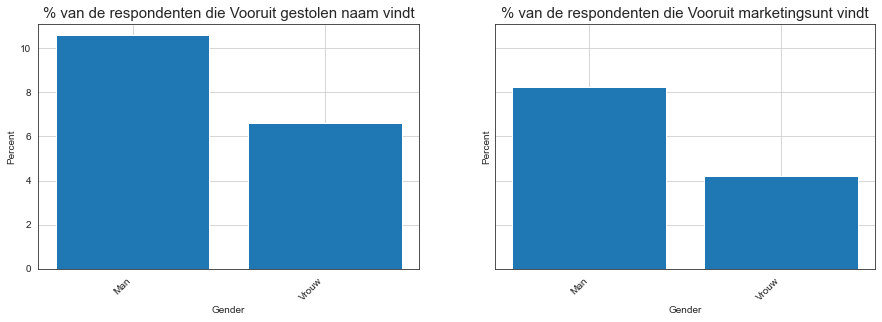

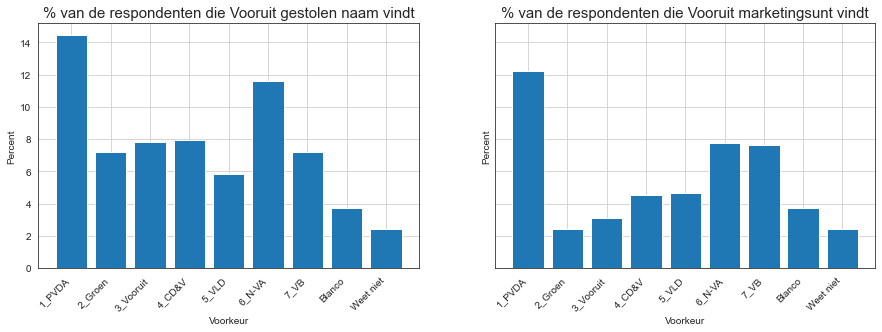

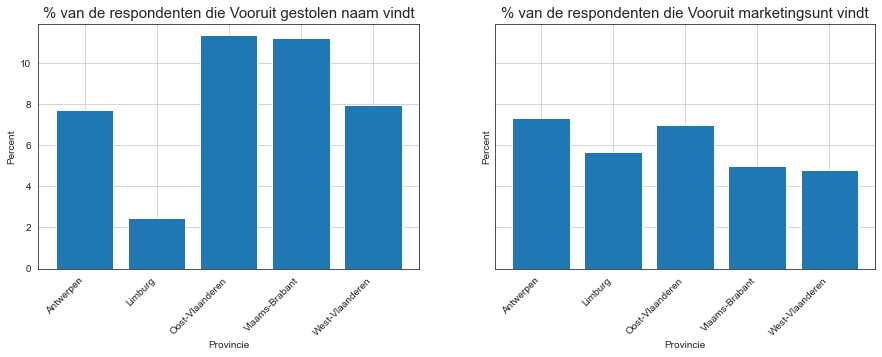

In [577]:
# Vernieuwend
data_copy['Gestolen_naam'] = (data_copy['Label negatieve woorden Vooruit'] == 'Gestolen naam')

# Sociaal
data_copy['Marketingstunt'] = (data_copy['Label negatieve woorden Vooruit'] == 'Marketingstunt')


# Filter function
def filter_function(radio_buttons):
        
    grouped_data_gestolen_naam = data_copy.groupby(categorie_radio_buttons.value)['Gestolen_naam'].mean()*100
    grouped_data_marketing_stunt = data_copy.groupby(categorie_radio_buttons.value)['Marketingstunt'].mean()*100
    
    # Plot
    with output:
        
        output.clear_output(wait=True)
        
        fig, axes = plt.subplots(1,2,figsize=(15,5), sharey=True)
        
        axes[0].bar(height=grouped_data_gestolen_naam.values, tick_label=grouped_data_gestolen_naam.index, x=np.arange(len(grouped_data_gestolen_naam)))
        axes[0].grid()
        axes[0].set_title('% van de respondenten die Vooruit gestolen naam vindt', size=15)
        axes[0].set_ylabel('Percent')
        axes[0].set_xlabel(categorie_radio_buttons.value)

        axes[1].bar(height=grouped_data_marketing_stunt.values, tick_label=grouped_data_marketing_stunt.index, x=np.arange(len(grouped_data_marketing_stunt)))
        axes[1].grid()
        axes[1].set_title('% van de respondenten die Vooruit marketingsunt vindt', size=15)
        axes[1].set_ylabel('Percent')
        axes[1].set_xlabel(categorie_radio_buttons.value)

        fig.autofmt_xdate(rotation=45 )        
        
# Categorie buttons
categorie_radio_buttons = widgets.RadioButtons(
    options=['Voorkeur', 'Gender', 'Provincie'],
    description='Categorie: ',
    disabled=False,
    value='Voorkeur',
)
categorie_radio_buttons.observe(filter_function, names=['value'])

# HBox with all the filters
input_widgets = widgets.HBox([categorie_radio_buttons])
display(input_widgets)



# Output
output = widgets.Output()
display(output)
    


In [517]:
for i, label in enumerate((data_raw['Label negatieve woorden Vooruit'].value_counts().index)):
    if(label in ['Geen', 'Ongeldig', 'Geen idee']): continue
    
    subset = data_raw.loc[data_raw['Label negatieve woorden Vooruit']==label,:]
    print('\n')
    print(label + ' (totaal: {})'.format(len(subset)))
    print('-----------------')
    
    for to_print in subset['Negatieve woorden Vooruit (vroeger sp.a) te omschrijven?'].sample(min(5, len(subset))).values:
        print(to_print)



Gestolen naam (totaal: 86)
-----------------
de overname van een naam die al door een ander werd gebruikt
plagiaat
vooruit gent
dieven
erg dat je creatief zo dood bent dat je een naam moet stelen


Marketingstunt (totaal: 61)
-----------------
wanhoopsreactie
het vroegere socialisme kreeg een nieuw maatpak met witte basketsloefkes eronder.
arrogant
er is door die naamsverandering niets concreets veranderd aan deze partij
nog belachelijker


Slechte naamkeuze (totaal: 41)
-----------------
inspiratieloos
heb ik reeds gedaan . het trekt op niks die naamsverandering.
stom om te veranderen wat iedereen al kent
te veel woordspelingen mogelijk
niet origineel en negatief voor mensen met minder kansen/mogelijkheden


Alles (totaal: 41)
-----------------
alles
ronduit slecht
jaa
slecht, slechter, slechtst
trekt op niets


Ontbreekt daadkracht (totaal: 40)
-----------------
de laatste maanden niet zo stabiel
veel blabla maar weinig concreet
de meeste rode dromen zijn bedrog
door slechte verkie

## Gevoelens van potentieel kiezers Vooruit

In [636]:
row_mask = (data_raw['Pot Vooruit']=='Ja')
pot_vooruit = data_raw.loc[row_mask,:].copy()

Text(0.5, 0, 'Huidige voorkeur')

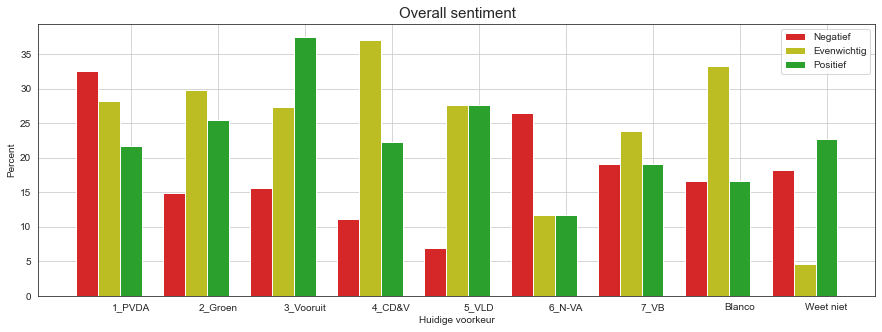

In [637]:
overall_sentiment = pot_vooruit.groupby('Voorkeur')['Overall sentiment'].value_counts(normalize=True)
overall_sentiment = overall_sentiment.reset_index(level=0)
overall_sentiment.columns = ['Voorkeur', 'Percent']
overall_sentiment['Percent'] = overall_sentiment['Percent']*100
overall_sentiment = overall_sentiment.reset_index()

overall_sentiment = overall_sentiment.loc[~overall_sentiment['Voorkeur'].isin(['Weiger', 'Niet stemmen', 'Ander']),:]

fig, ax = plt.subplots(1,1, figsize=(15, 5))

row_mask = (overall_sentiment['Overall sentiment']=='Negatief')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))-0.25, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Negatief', color='C3', width=0.25)

row_mask = (overall_sentiment['Overall sentiment']=='Evenwichtig')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))+0, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Evenwichtig', color='C8', width=0.25)

row_mask = (overall_sentiment['Overall sentiment']=='Positief')
ax.bar(height=overall_sentiment.loc[row_mask,'Percent'], x=np.arange(sum(row_mask))+0.25, tick_label=overall_sentiment.loc[row_mask,'Voorkeur'], 
       label='Positief', color='C2', width=0.25)


ax.set_title('Overall sentiment', size=15)
ax.grid()
ax.legend()
ax.set_ylabel('Percent')
ax.set_xlabel('Huidige voorkeur')


In [635]:


for i, label in enumerate((pot_vooruit['Label positieve woorden Vooruit'].value_counts().index)):
    if(label in ['Geen', 'Ongeldig', 'Geen idee']): continue
    
    subset = pot_vooruit.loc[pot_vooruit['Label positieve woorden Vooruit']==label,:]
    print('\n')
    print(label + ' (totaal: {})'.format(len(subset)))
    print('-----------------')
    
    for to_print in subset['Positieve woorden om Vooruit (vroeger sp.a) te omschrijven?'].sample(min(5, len(subset))).values:
        print(to_print)



Innovatie - Vernieuwing (totaal: 65)
-----------------
sociaal, progressief
ze willen vooruit
progressief
dat we vooruit moeten gaan
positieve uitstraling, verjonging, duidelijker standpunten, verantwoordelijkheid


Sociaal (totaal: 29)
-----------------
sociaal bewogen
socialistisch
sociaal
sociaal bewogen
sociaal


Gedrag: Gedreven (totaal: 15)
-----------------
en nu vooruit
ze willen vooruit met de maatregelen
ze hebben altijd vooruit gewillen zeker voor de arbeiders en hun gezinnen ,er waren zelfs de vooruitziende vrouwen
vooruit en niet achteruit
gaan ervoir


Leiderschap: Toekomstgericht (totaal: 10)
-----------------
blik naar de toekomst
we kijken meer naar de toekomst
moet positief zojn
positief denken
goede toekomst


DG: Werkende mens (totaal: 9)
-----------------
komt meer op voor het gewone werkvolk
voor het volk
volks
sociaal, voor de werkende mens (niet voor de grote bedrijven), vredelievend, beleefd, respectvol, bekwaam
komen op voor de werkende mensen


Brand identi

In [ ]:
# TO DO
# ---
# Kernthema's optellen
# DG: Doelgroep
# Verschil SPA - Vooruit, ook kijken naar label
